In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-nepali/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-nepali/classification')

In [6]:
!ls

Nepali_Classification_Model.ipynb  Nepali_News_Classification.csv


In [7]:
df = pd.read_csv(path/'Nepali_News_Classification.csv')
df.tail()

,headings,paras,label
7465,‘एक्ली’ नविता,टेबलटेनिसकी नम्बर वान खेलाडी नविता श्रेष्ठ शनि...,sports
7466,आयोजक र विराटनगर विजयी,दोस्रो यू–१९ इटहरी प्रिमियर लिग क्रिकेटमा शनिब...,sports
7467,ललितपुरलाई ५ स्वर्ण,धनकुटामा हुने राष्ट्रिय प्रतियोगिताका लागि हेट...,sports
7468,नारायण र लक्ष्मीलाई स्वर्ण,काठमाडौंका नारायणगोपाल महर्जन र नुवाकोटकी लक्ष...,sports
7469,नेपाल समूह चरणबाटै बाहिरियो,दृष्टिविहीन वान डे विश्वकप क्रिकेटअन्तर्गत समू...,sports


In [8]:
df['label'].unique()

array(['entertainment', 'business', 'sports'], dtype=object)

In [9]:
print('Entertainment', (df['label'] == 'entertainment').sum())
print('Business', (df['label'] == 'business').sum())
print('Sports', (df['label'] == 'sports').sum())

Entertainment 2268
Business 2628
Sports 2574


In [10]:
df['headings'][0]

'कर्णालीका सुइना'

In [11]:
df.shape

(7470, 3)

In [12]:
df[df['headings'].isnull()].shape, df[df['paras'].isnull()].shape

((0, 3), (0, 3))

In [13]:
label_cols = list(range(2,df.shape[1]))

In [14]:
print(label_cols)

[2]


In [15]:
id_to_col = list(df.columns)

In [16]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [17]:
class NepaliTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/nepali_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/nepali_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(15000)]

In [19]:
itos

['<unk>',
 '<s>',
 '</s>',
 '▁',
 'को',
 '।',
 ',',
 'मा',
 '▁।',
 '▁र',
 '.',
 'ले',
 'का',
 '▁छ',
 '▁हो',
 'लाई',
 '▁•',
 '▁यो',
 '▁q',
 '▁�',
 '▁पनि',
 '▁एक',
 'X',
 '▁यस',
 '▁थियो',
 'बाट',
 '▁तथा',
 'न',
 'ी',
 '▁भएको',
 '-',
 'हरू',
 '▁छन्',
 '�',
 '▁थिए',
 '▁रहेको',
 '▁मा',
 'र',
 'ा',
 '▁लागि',
 'े',
 '▁भने',
 'क',
 '▁हुन्छ',
 'स',
 '▁वा',
 '▁गर्ने',
 '▁गर्न',
 '▁रूपमा',
 ':',
 '▁हुन्',
 '▁आफ्नो',
 '▁विकास',
 '▁नेपाली',
 'म',
 '▁नेपालको',
 '▁सन्',
 '▁नेपाल',
 'ल',
 'ला',
 '▁नै',
 '▁गरेको',
 '▁उनले',
 '▁को',
 '▁गरिएको',
 '▁उनी',
 'हरु',
 '▁तर',
 'ता',
 '▁गरे',
 '▁वि',
 '▁गरेका',
 '▁यसको',
 '▁नाम',
 'हरूको',
 '▁अनुसार',
 '▁हुने',
 '▁वर्ष',
 '▁देखि',
 '▁क्षेत्र',
 'ि',
 '▁धेरै',
 '▁हुन',
 'ै',
 '▁एउटा',
 'ं',
 '▁दिन',
 'सँग',
 '▁जिल्ला',
 '▁गरिन्छ',
 '▁भन्ने',
 "'",
 'त',
 '▁गरी',
 '▁अ',
 '▁उनको',
 '्',
 '▁कुनै',
 'द्वारा',
 'ित',
 '▁पछि',
 '▁सबै',
 'ो',
 'की',
 '▁भयो',
 '▁अवस्थित',
 '▁जिल्लामा',
 '▁जन्म',
 'देखि',
 '▁जिल्लाको',
 '▁गाउँ',
 '▁केही',
 '"',
 '▁समिति',
 '▁राष्ट्रिय',


In [20]:
# 15,000 is the vocab size that we chose in sentencepiece
nepali_vocab = Vocab(itos)

In [21]:
tokenizer = Tokenizer(tok_func=NepaliTokenizer, lang='ne')

In [22]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [23]:
data_lm = TextDataBunch.from_csv(path=path, csv_name='Nepali_News_Classification.csv', text_cols=[0,1], label_cols=label_cols, tokenizer=tokenizer, vocab=nepali_vocab)

In [24]:
data_lm.save()

In [25]:
bs=48

In [26]:
data_lm = TextLMDataBunch.load(path, 'tmp', bs=bs)

In [27]:
data_lm.show_batch()

idx,text
0,▁ x x b os ▁से ले ब्रिट ी ▁बेस्ट ▁ फ्रेन्ड ्स ▁सामाजिक ▁सञ्जाल तिर ▁आइतबार ▁ फ्रेन्ड सिप सम्बन्धी ▁पोस्ट ▁धेरै ▁देखिए ▁। ▁अगस्ट को ▁पहिलो ▁आइतबार लाई ▁इन्टरनेसनल ▁ फ्रेन्ड सिप ▁डे का ▁रूपमा ▁मनाउने ▁गरिएको ▁छ ▁। ▁ x x b os ▁यु भ ेन्ट ्स को ▁रोमाञ्च क ▁जित ▁मा उ रिस ियो ▁पो चे टि नो ले ▁सम्हाले को ▁टो टेन हम ले ▁दुई
1,▁ ▁लाख ▁जरिवाना ▁सर् त अनुसार ▁काम ▁नगरे को ▁भन्दै ▁नेपाल ▁दूरसञ्चार ▁प्राधिकरण ले ▁यू टी एल ▁र ▁स्मार्ट ▁टेलिकम लाई ▁ – ▁लाख ▁रुपैयाँ ▁जरिवाना ▁गर्ने ▁निर्णय ▁गरेको ▁छ ▁। ▁ x x b os ▁प्रदीप – जस िता ▁‘ ल भ ▁स्टेसन ’ ▁मा ▁अभिनेता ▁प्रदीप ▁खड्का ले ▁‘ लि ली बि ली ’ ▁मा ▁अभिनेत्री का ▁रूपमा ▁डेब्यु ▁गर् ल ▁जस िता ▁गुरुङ लाई
2,’ ▁वैशाख ▁ ▁देखि ▁देशभर ▁प्रदर्शन ▁हुने ▁भएको ▁छ ▁। ▁एक ▁युवा को ▁जीवनमा ▁आइ पर्ने ▁विभिन्न ▁उतार च ढा ब ▁कथामा ▁समेटिए को ▁निर्देशक ▁गोपाल चन्द्र ▁घिमिरे ले ▁बताए ▁। ▁ x x b os ▁अजय को ▁ग्रिन ▁सिग्नल ▁बलिउड ▁अभिनेत्री ▁का जो ल ▁र ▁निर्माता ▁/ ▁निर्देशक ▁ करण ▁जौ हर ▁ गत ▁वर्षको ▁कु ख्या त ▁भ ना भन अघि सम्म ▁अति ▁घनिष्ठ ▁थिए ▁। ▁का
3,"▁भावना ▁बोल्ने ▁‘ ड न्ट ▁कि ल ▁मि ’ ▁सार्वजनिक ▁देशमा ▁विद्यमान ▁भ्रम ▁हत्या ▁अर्थात् ▁गर्भपतन ▁विरुद्ध ▁आवाज ▁उठाउने ▁शैलीको ▁एउटा ▁गीत को ▁म्युजिक ▁भिडियो ▁सार्वजनिक ▁भएको ▁छ ▁। ▁ ▁वर्षीय ा ▁किशोर ी ▁गायिका ▁ प्रे गि शा ▁पौडेल को ▁स्वर मा ▁तयार ▁पारिएको ▁‘ न मा र ▁मलाई , ▁न फाल ▁मलाई . . ’ ▁गीत को ▁म्युजिक ▁भिडियो मा ▁कुमारी ▁अवस्था मै ▁गर्भवती ▁भएकी ▁एउटी ▁किशोर"
4,x x b os ▁मन ी षा लाई ▁दा दा ▁ साहेब ▁अभिनेत्री ▁मन ी षा ▁कोइराला ले ▁भारतको ▁प्रतिष्ठित ▁दा दा ▁ साहेब ▁फाल ्के ▁अवार्ड ▁पाए की ▁छन् ▁। ▁उनलाई ▁‘ मो स्ट ▁ भर्स टा यल ▁एक ्ट ्रे स ▁अवार्ड ’ ▁प्रदान ▁गरिएको ▁छ ▁। ▁ x x b os ▁र ुवा उने ▁‘ बु ख्या ँ चा ▁मन ’ ▁कानुन त : ▁छुवाछुत ▁वर्जित ▁रहे


In [28]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [29]:
# Loading the pretrained language model on nepali wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-nepali/language-model/NepaliDataset/models/third_ne_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (5975 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-nepali/classification
x: LMTextList (5975 items)
[Text ▁ x x b os ▁हिमालय ▁ट्रा भल ▁मा र्ट ▁जेठ ▁ <unk> ▁मा ▁पर्यटन ▁बोर्ड को ▁डेढ ▁करोड ▁लगानी मा ▁जेठ ▁ <unk> ▁देखी ▁काठमाडौंमा ▁हुने ▁दोस्रो ▁हिमालय ▁ट्रा भल ▁मा र्ट मा ▁ <unk> ▁मुलुक का ▁ <unk> ▁सय ▁ <unk> ▁पर्यटन ▁प्रतिनिधि ▁काठमाडौंमा ▁आउने ▁भएका ▁छन् ▁।, Text ▁ x x b os ▁खाद्य का ▁महा प्र बन्ध क ▁गौ चन ▁भन्छन् – ▁‘ स ञ् चालक ले ▁जोखिम ▁उठाए नन् ’ ▁खाद्य ▁संस्थान ▁सम्हाले को ▁करिब ▁ <unk> ▁महिना ▁भयो ▁। ▁आपूर्ति ▁विभाग ▁र ▁संस्थान ▁जन स रो कार का ▁संवेदनशील ▁निकाय ▁भएकाले ▁भ्या इ – न भ्य ाइ ▁छ ▁। ▁आपूर्ति ▁विभाग ▁र ▁संस्थान को ▁पूर्व देखि ▁पश्चिम बाट ▁गुनासो ▁मात्रै ▁सुनेर ▁दिन ▁व्य ती त ▁भएको ▁छ ▁।, Text ▁ x x b os ▁के एन पी ▁मुख्य ▁प्रायोजक ▁के एन पी ▁जा पन ▁प्रा ली ले ▁शेर बहादुर ▁खडा ▁स्मृति ▁प्रतिष्ठान को ▁आयोजना मा ▁सञ्चालन ▁हुने ▁राष्ट्रिय ▁म

In [30]:
# Fine tuning the prtrained LM on current dataset

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


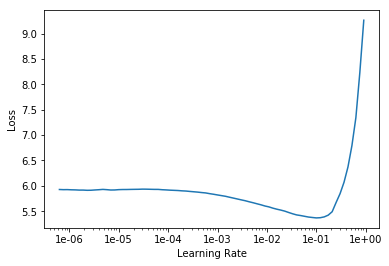

In [32]:
learn.recorder.plot()

In [33]:
learn.freeze()

In [34]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.880709,4.552991,0.311447


In [35]:
learn.save('fit_head', with_opt=True)

In [36]:
learn.load('fit_head', with_opt=True);

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.434771,4.443220,0.320628
2,4.271987,4.273796,0.338242
3,4.070199,4.132339,0.355008
4,3.823803,4.043192,0.366492
5,3.614245,3.997600,0.373506
6,3.430835,3.977136,0.377413
7,3.303760,3.970657,0.379123
8,3.191732,3.974438,0.380518
9,3.119445,3.977446,0.380585
10,3.095051,3.978210,0.380891


In [39]:
learn.save('fine_tuned', with_opt=True)

In [40]:
learn.load('fine_tuned', with_opt=True);

In [41]:
learn.predict('हिमालय ट्राभल',n_words=10)

'हिमालय ट्राभल ▁खीर ▁विकेट . . ▁ ▁फल ▁बीचको ▁लाल िना को'

In [42]:
learn.save_encoder('fine_tuned_enc')

In [43]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='Nepali_News_Classification.csv', tokenizer=tokenizer, vocab=nepali_vocab, text_cols=[0,1], label_cols=label_cols)

In [44]:
data_clas.show_batch()

text,target
▁ x x b os ▁गुरुकुल ▁न खु ले को ▁भए ▁रक्सी ▁बेच िरहेको ▁हुन्थे ं ▁: ▁' भ ष् मे ▁ डन ' ▁उम् दा ▁अनुहार ▁पनि ▁हैन ▁। ▁बलि ष्ठ ▁ज्यान ▁पनि ▁छैन ▁। ▁तर ▁वि पि न ▁कार्की ▁‘ हि रो ’ ▁बनेर ▁देखिए ▁‘ जात्रा ’ ▁मा ▁। ▁हुन ▁त ▁त्यसअघि ▁नै ▁उनी ▁‘ प शु पति ▁प्रसाद ’ ▁बाट ▁भ ष् मे ▁ डन का,entertainment
"▁ x x b os ▁‘ ल ख पति ▁माग्ने ’ ▁घोषणा , ▁‘ जु भिन ाइ ल ’ ▁को ▁गीत ▁प्रथम ▁महिला ▁सिनेमा टो ग्राफ र ▁हुन् ▁श बन म ▁मुखिया ▁। ▁ड कु मेन्ट ्री ▁हुँदै ▁फिल्म ▁क्षेत्रमा ▁प्रवेश ▁गरेकी ▁मुखिया ▁यति ▁बेला ▁भने ▁ध मा ध म ▁निर्देशन तिर ▁लागे की ▁छन् ▁। ▁राजधानी मा ▁मंगलबार ▁उनले ▁निर्देशन ▁रहने ▁‘ ल ख पति ▁माग्ने ’ ▁फिल्म ▁घोषणा",entertainment
"▁ x x b os ▁पर्यटक को ▁रोज ाइ मा ▁‘ बी ए न्ड बी ’ ▁जापान की ▁अ की ▁सु गि मो तो ▁नेपाल ▁आउँदा ▁तार े ▁होटल मा ▁ब स् दिन न् ▁। ▁उनलाई ▁ग ेस्ट हाउस , ▁होम स्टे , ▁होस् टल , ▁रिस ो र्ट ▁वा ▁अ पा र्ट मेन्ट भन्दा ▁बे ड ▁एन्ड ▁ ब्रेक फा स्ट ▁ ( बी ए न्ड बी ) ▁इन",business
▁ x x b os ▁वन को ▁का फल ▁खाने ▁कोही ▁छैन ... भि डियो सहित ▁नेपाली ▁समाजको ▁यथार्थ ता ▁झल्क िने ▁पूर्व ेली ▁लोकगीत ▁‘ व नै को ▁का फल ’ बजार मा ▁आएको ▁छ ▁। ▁कलाकार द्वय ▁नवीन ▁राना ▁र ▁भीमसेन ▁क ँ डेल को ▁संयुक्त ▁प्रस्तुति मा ▁उक्त ▁गीत ▁सार्वजनिक ▁भएको ▁हो ▁। ▁टाई ग र्स ▁फिल्म स् को ▁प्रस्तुति ▁रहेको ▁वन ै को ▁का,entertainment
"▁ x x b os ▁जसलाई ▁गर्नु ▁छैन ▁मे क अप ▁उमेर सँगै ▁सुन्दर ▁देखिने ▁चाह ▁तीव्र ▁हुँदै ▁जान्छ ▁। ▁स्कुल ▁पढ्ने ▁बेला देखि ▁नै ▁युवती हरू ▁थ्र ेड िङ , ▁क्लि न ज िङ ▁जस्ता ▁ब ्यु टी ▁ट्र िट मेन्ट ▁सुरु ▁गर्छन् ▁। ▁जवान ▁भएपछि ▁मे क अप का ▁अनेक ▁तौर तर िका ▁अपनाउन े ▁गरिन्छ ▁। ▁ग्ल ्या मर ▁क्षेत्र ▁रोज ्ने लाई ▁मे क अप ▁अत्यावश्यक",entertainment


In [45]:
data_clas.sanity_check()

In [46]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [47]:
learn.load_encoder('fine_tuned_enc')

In [48]:
learn.freeze()

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


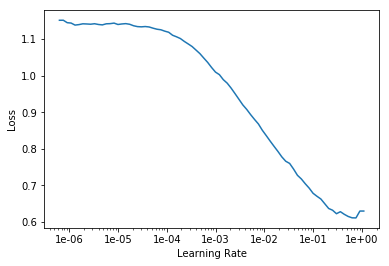

In [50]:
learn.recorder.plot()

In [51]:
learn.loss_func.func

CrossEntropyLoss()

In [52]:
kappa = KappaScore()

In [53]:
learn.metrics = [kappa, accuracy]

In [54]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.206585,0.094375,0.954797,0.969900


In [55]:
learn.save('first-full')

In [56]:
learn.load('first-full');

In [57]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.165279,0.096759,0.952760,0.968562
2,0.148447,0.077497,0.956785,0.971237
3,0.094400,0.072739,0.967847,0.978595
4,0.069019,0.071308,0.965841,0.977258
5,0.059711,0.068303,0.964840,0.976589


In [58]:
learn.save('final')

In [59]:
learn.predict('फेसबुकले बेहोर्‍यो हालसम्मकै सबभन्दा खराब समस्या')

(Category business, tensor(0), tensor([0.7988, 0.1876, 0.0136]))

In [60]:
learn.predict("साफ महिला च्याम्पियनसिप : बंगालदेश र भुटान भिड्दै")

(Category sports, tensor(2), tensor([2.3490e-07, 1.2754e-04, 9.9987e-01]))

In [61]:
learn.predict("अष्ट्रेलियालाई एकदिवसीय सिरिज, घरेलु मैदानमा गुमायो भारतले मौका")

(Category sports, tensor(2), tensor([2.4508e-03, 3.9204e-05, 9.9751e-01]))

In [62]:
learn.predict("बंगलादेशविरुद्ध टेस्ट सिरज न्यूजिल्यान्डले जित्यो")

(Category sports, tensor(2), tensor([3.5151e-05, 1.3409e-04, 9.9983e-01]))

In [63]:
learn.predict("लगानी सम्मेलनमा प्रस्तुत गर्न ४३ परियोजना निश्चित")

(Category business, tensor(0), tensor([9.9870e-01, 1.0885e-03, 2.0831e-04]))